<a href="https://colab.research.google.com/github/british2002/tsml-18/blob/main/%D0%94%D0%97_%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D0%B5%D0%BA%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_(SSA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

1.   Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
2.   При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.
3.   Посмотрите на результаты с разными длинами окон.
4.   Обязательно визуализируйте результаты аналогично материалу с занятия.

# Часть 0. Подготовка данных

In [9]:
#импортируем пакеты для работы
import numpy as np
import pandas as pd
from numpy import pi
import matplotlib.pyplot as plt
from cycler import cycler

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [2]:
#задаем параметры графика (размер, шрифт, тип карты, размерность 2D)
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

#установим цвета по умолчанию
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

#зададим функцию двумерного графика
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [3]:
#загружаем данные для анализа и работы
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")

In [10]:
#определим функцию Дики-Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [11]:
#определим функцию построения графиков (оригинал, автокорреляция, парной автокорреляции)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


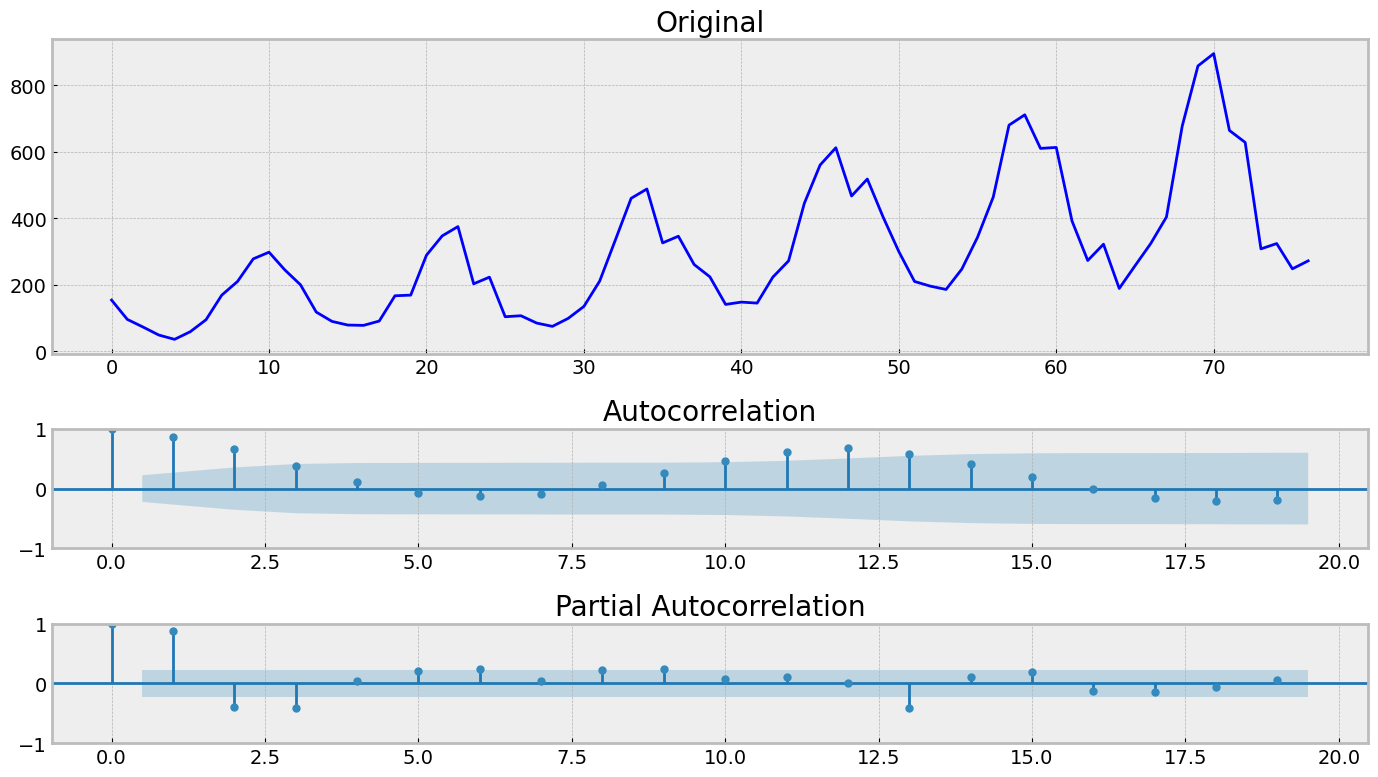

In [12]:
#проанализируем данные в monthly-sales-of-company-x-jan-6.csv
series = sales_of_company_x['Count']
tsplot(series)

# Часть 1. SSA

In [27]:
#определим N и t в зависимости от числа значений временного ряда
N = len(series)
t = np.arange(0,N)

#зададим размер окна
L = 40

#определим количество столбцов матрицы траектории
K = N - L + 1

#создадим матрицу траектории
X = np.column_stack([series[i:i+L] for i in range(0,K)])

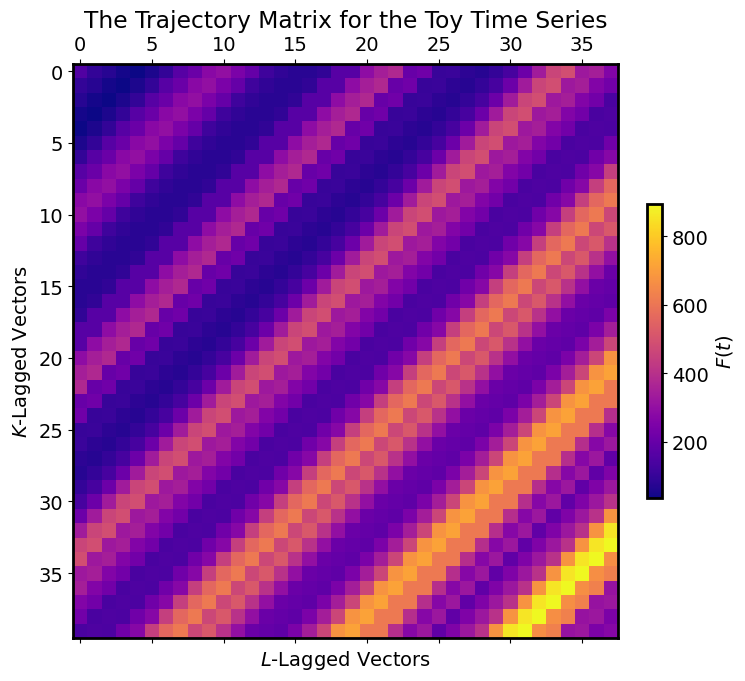

In [28]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

In [29]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless,
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i).
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

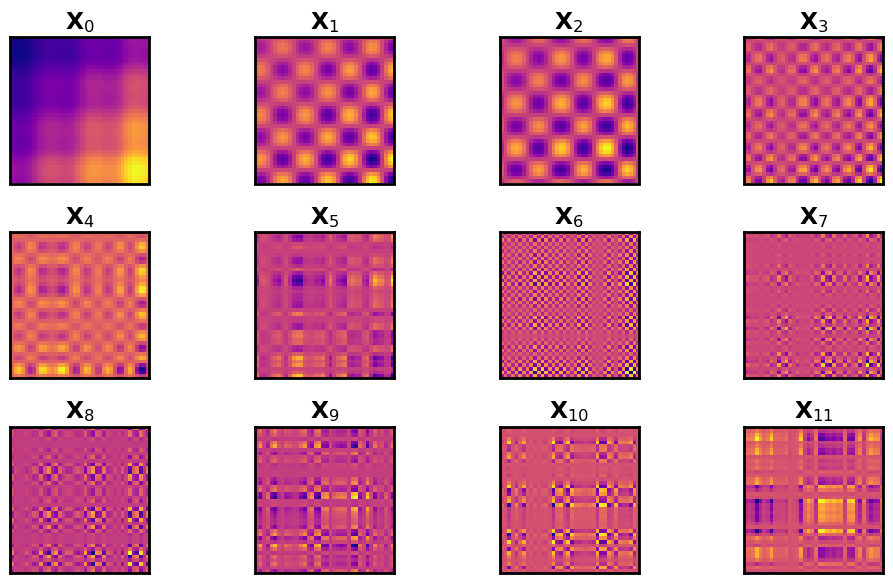

In [30]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Из графиков выше видно, что наиболее интересны являются X0 (вероятно тренд), Х1, Х2. Возможно Х3 также "вносит вклад" в общий расклад. Проверим это ниже.

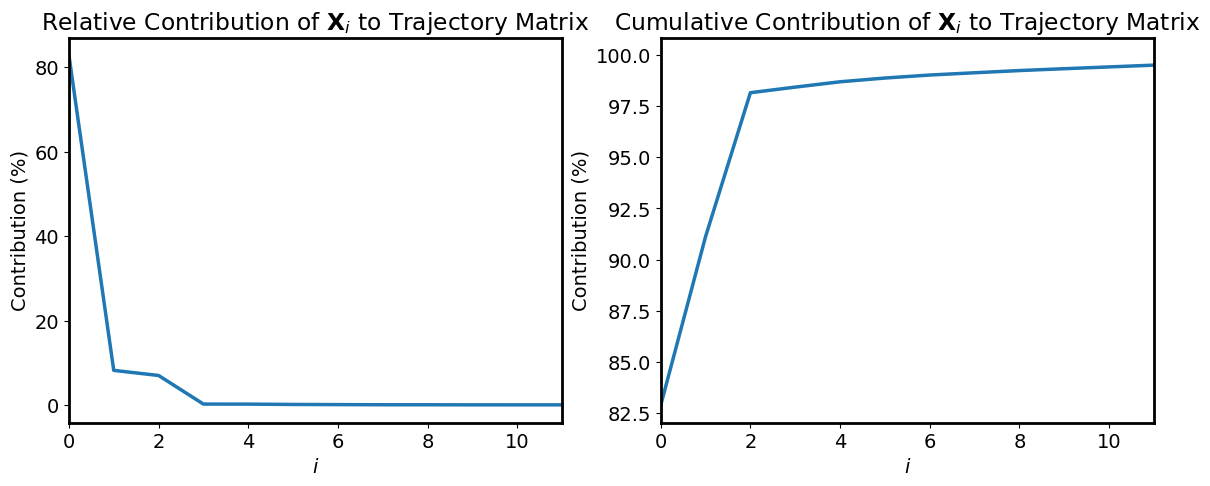

In [31]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

Как и ожидалось, основной вклад вносит Х0 (81%), Х1 (~ 10%), Х2 (~7%); суммарно эти компоненты дают около 98%.

In [32]:
#зададим функцию "ганкелизации"
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

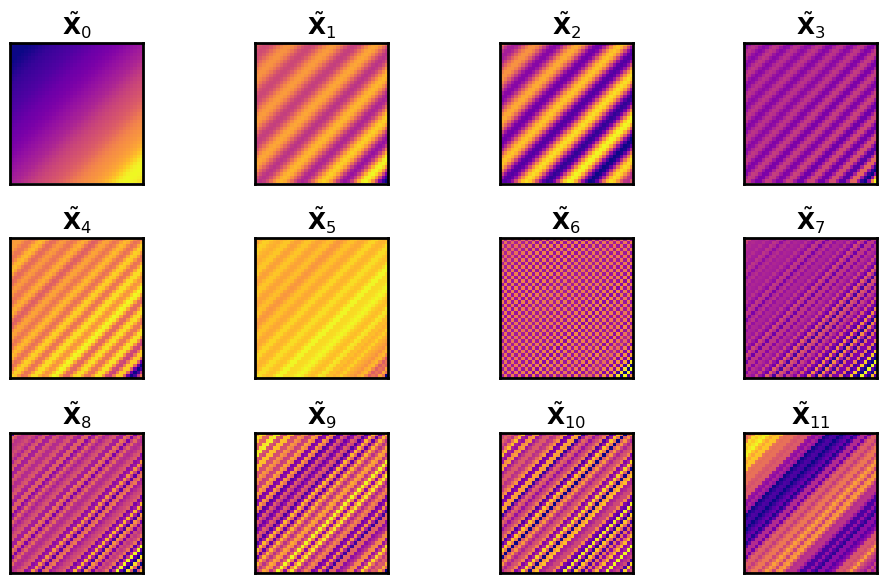

In [33]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

Из графиков выше можно сделать выводы:


*   Х0 меняется медленно, вероятно это тренд;
*   Х1 и Х2 меняются периодическими с одинаковой частотой и могут быть сгруппированы как первый периодический компонент;
*   Х3, Х4 и Х5  также являются периодическими, с другой частотой, чем  Х1 и  X3, сгруппируем их как второй периодический компонент.
*   Остальные компоненты объединим в шум


In [34]:
#определим функцию формирования временного ряда
def X_to_TS(X_i):
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

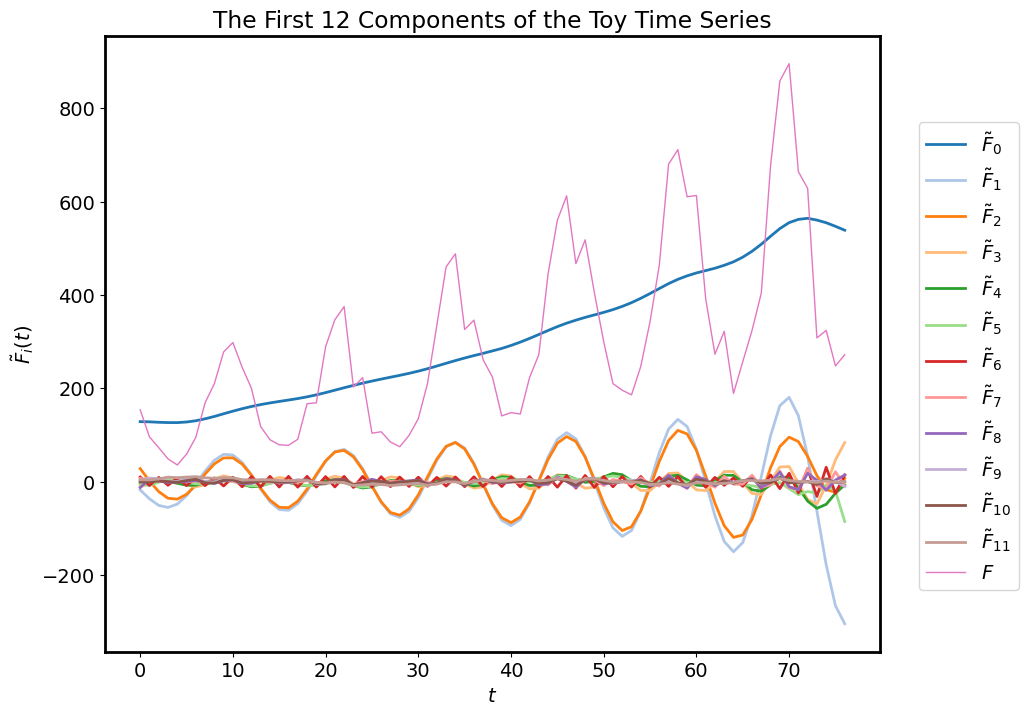

In [38]:
#построим все 12 графиков
n = min(12,d)

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

#перобразуем матрицы в графики временного ряда
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

Как и предполагал выше, Х0 - тренд, Х1 и Х2 - схожи и могут быть сгруппированы, Х3, Х4 и Х5 плохо различимы на общей картине. Ниже избавлюсь от всех других компонент Х6-Х11.

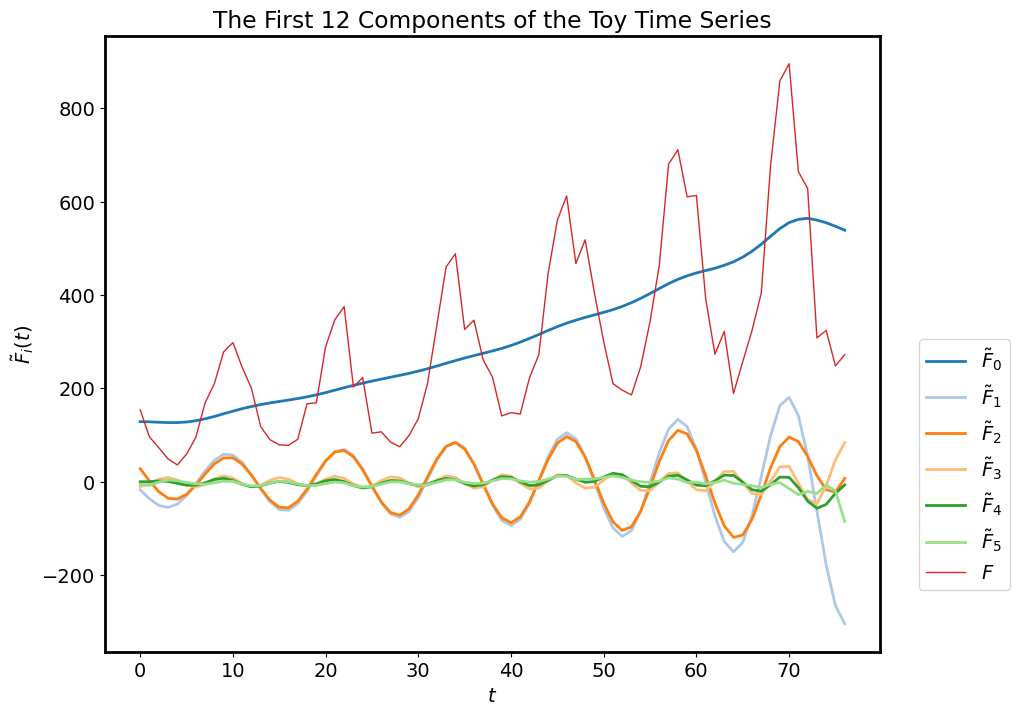

In [40]:
#построим первые 6 графиков
n = min(6,d)

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

#перобразуем матрицы в графики временного ряда
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

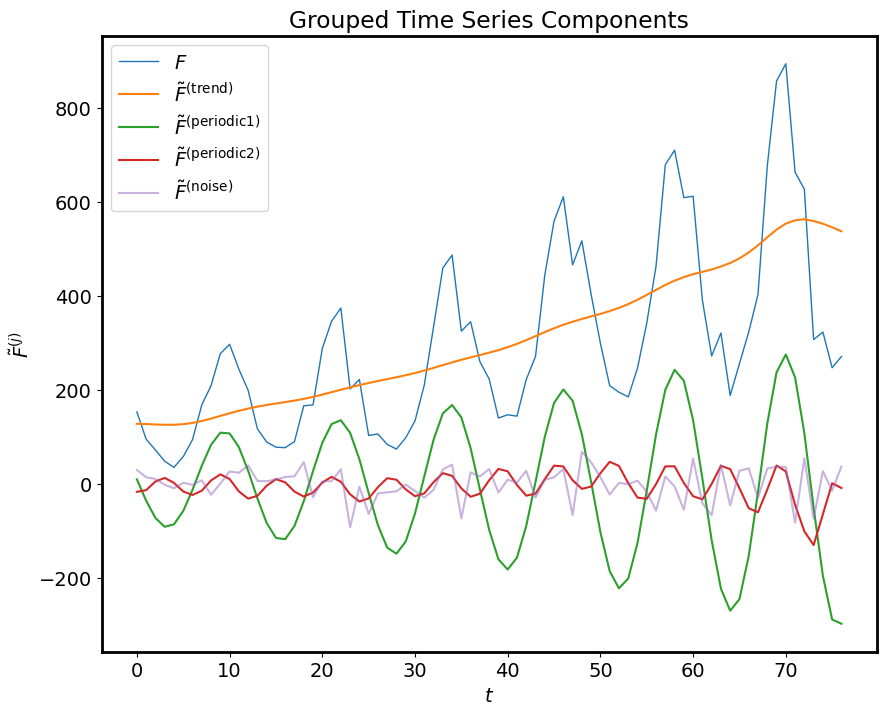

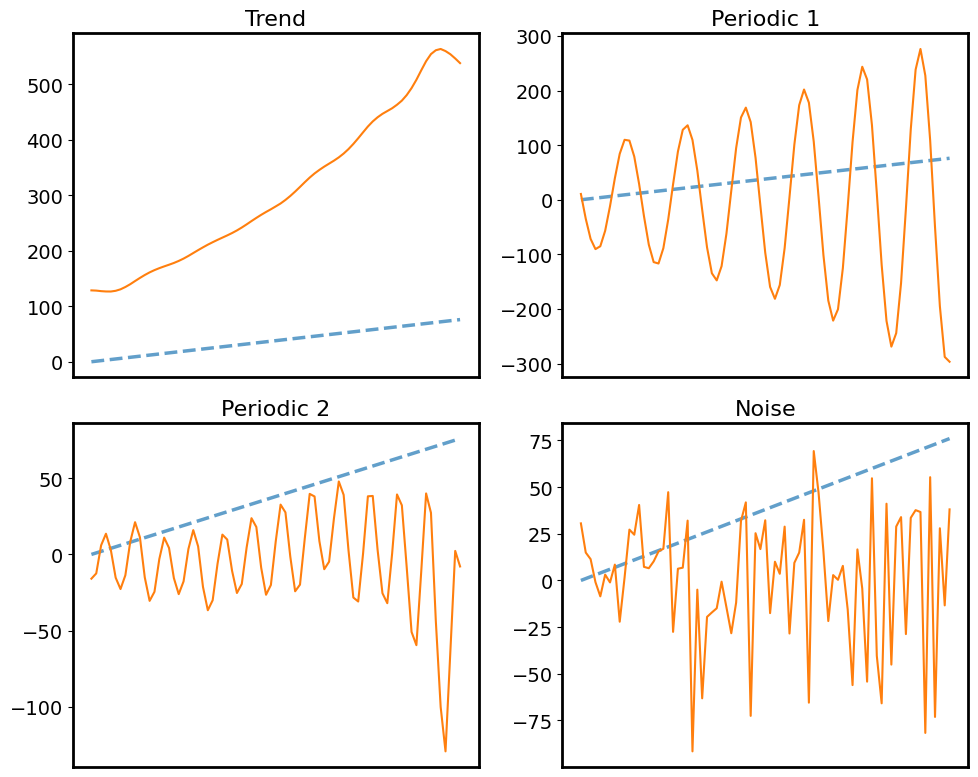

In [45]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[3,4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[6:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,series, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", F_trend),
              ("Periodic 1", F_periodic1),
              ("Periodic 2", F_periodic2),
              ("Noise", F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(t, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

# Часть 2. Анализ при различных размерах окон L

In [47]:
#зададим класс для сингулярного спектрального анализа
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Декомпозирует исходный временной ряд с помощью сингулярного спектрального анализа. Предполагается, что значения временного ряда
        записываются с равными интервалами.

        Параметры
        ----------
        tseries : Исходный временной ряд в формате Pandas Series, массива или списка NumPy.
        L : Длина окна, его значение должно быть целым числом и удовлетворять условию: 2 <= L <= N/2, где N — длина временного ряда.
        save_mem : Экономит память, не сохраняя элементарные матрицы. Рекомендуется для длинных временных рядов с
        тысячами значений. По умолчанию True.

        Примечание: даже если для исходного временного ряда используется массив или список NumPy, все возвращаемые временные ряды будут
        в форме объекта Pandas Series или DataFrame.
        """

        #проверка типов для начального временного ряда
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Неподдерживаемый объект временного ряда. Попробуйте Pandas Series, массив или список NumPy.")

        #проверки на выполнение условия для длины окна L
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("Длина окна L должна находиться в интервале [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        #внедрим временной ряд в матрицу траектории
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        #декомпозируем матрицу траектории
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            #строим и сохраняем все элементарные матрицы
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            #усредняем элементарные матрицы по диагонали, сохраняем их в виде столбцов в массиве.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            #восстановливаем элементарные матрицы, не сохраняя их
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Повторите запуск с save_mem=False, чтобы сохранить элементарные матрицы."

            #массив V также может оказаться очень большим в этих обстоятельствах, поэтому мы не будем его сохранять.
            self.V = "Повторите запуск с save_mem=False, чтобы сохранить матрицу V."

        #считаем матрицу w-корреляции.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Возвращает все компоненты временного ряда в одном объекте Pandas DataFrame.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        #создаем список столбцов F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Восстанавливает временной ряд из его элементарных компонентов, используя заданные индексы. Возвращает объект Pandas Series с восстановленным временным рядом.

        Параметры
        ----------
        indices: целое число, список целых чисел или объект slice(n,m), представляющий элементарные компоненты для суммирования.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Рассчитывает матрицу w-корреляции для временного ряда.
        """

        #рассчитаем веса
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        #считаем взвешенные нормы, ||F_i||_w, затем инвертируем.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        #считаем Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Строит график матрицы w-корреляции для разложенного временного ряда.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        #для построения графика
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

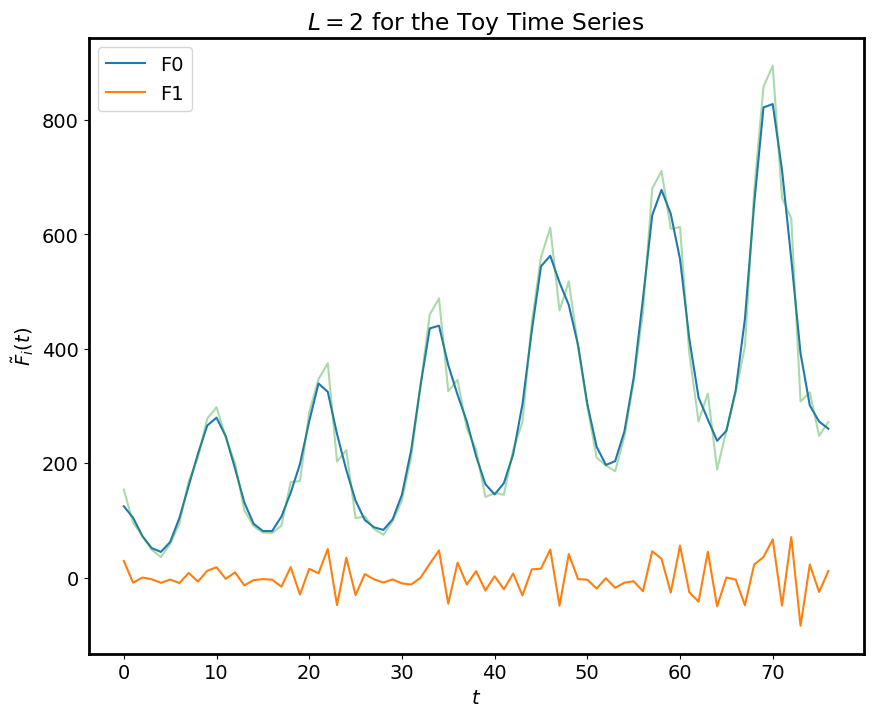

In [49]:
F_ssa_L2 = SSA(series, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series");

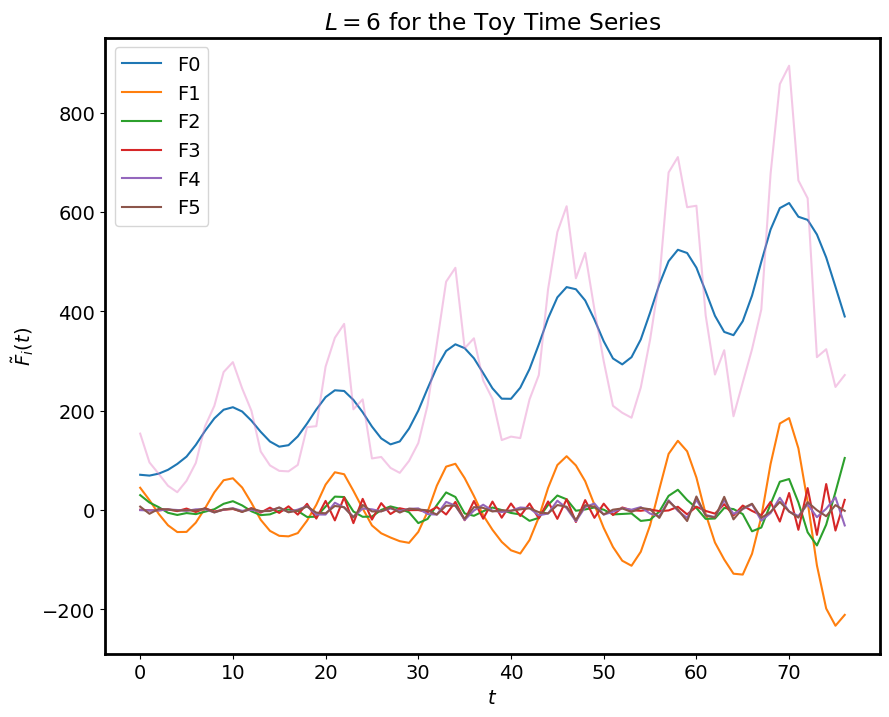

In [55]:
F_ssa_L2 = SSA(series, 6)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=6$ for the Toy Time Series");

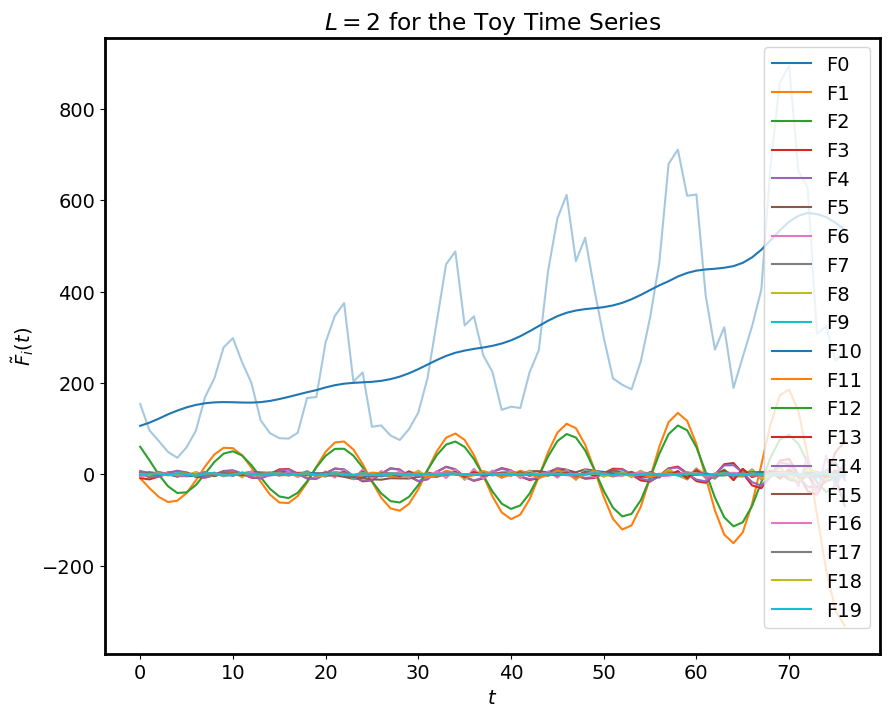

In [51]:
F_ssa_L2 = SSA(series, 20)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=20$ for the Toy Time Series");

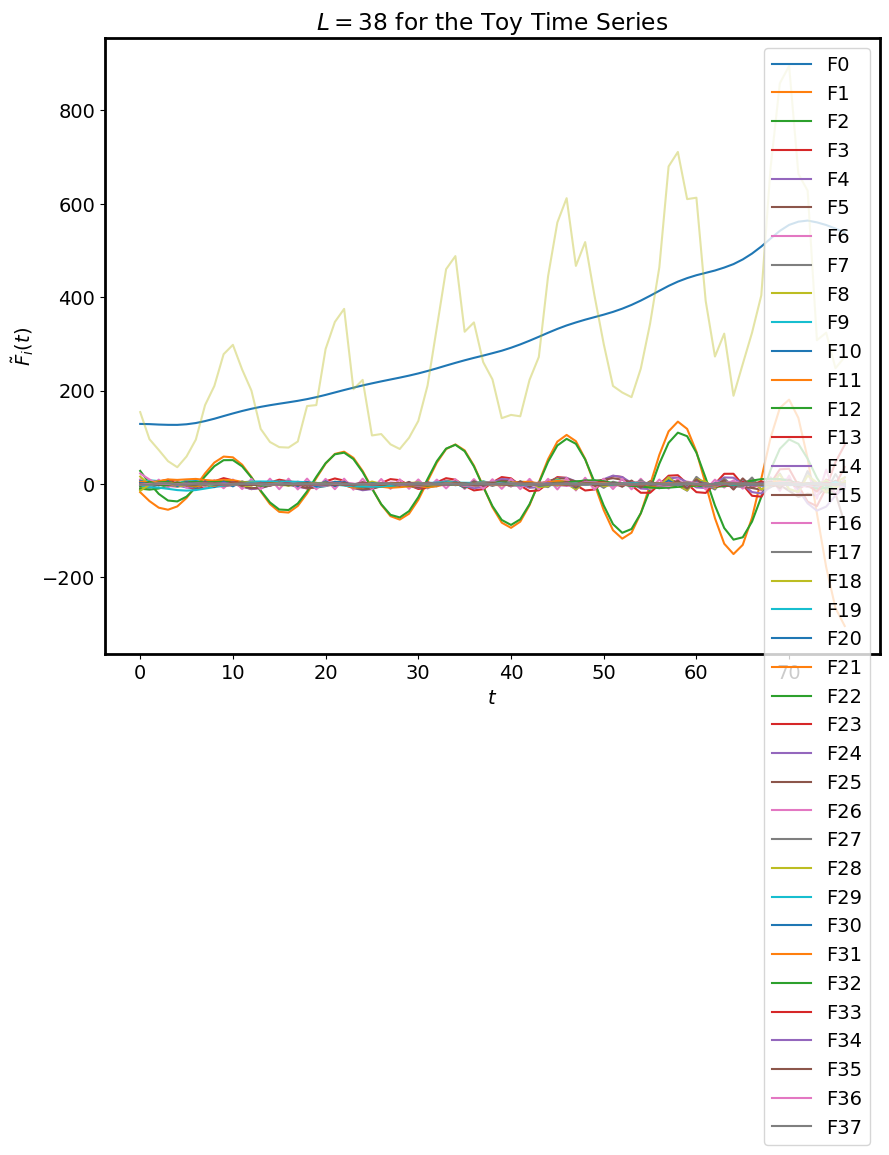

In [58]:
F_ssa_L2 = SSA(series, 38)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=38$ for the Toy Time Series");

**Выводы:**


*   При минимальной длине окна 2 получили схожий с реальным результат, но при этом получили только линию тренда и первой компоненты.
*   При длине равной 6 имеем оригинальный график, линию тренда и 2 основных компоненты; это оптимальный результат
*   При L = 20 помимо основных параметров (оригинал, тренд, 2 компоненты получили дополнительные шумовые линии, анализ которых избыточен
*   Максимальной для нашего ряда (77 значений) L = 38 избыточна